In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d ihelon/football-player-segmentation

100% 316M/317M [00:02<00:00, 112MB/s]
100% 317M/317M [00:02<00:00, 112MB/s]


In [4]:
!unzip -q football-player-segmentation.zip

In [55]:
!pip install imantics --q

In [56]:
import json
import os

import cv2
import imantics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from skimage.transform import resize

In [57]:
N_IMAGES = 512
TRAIN_IMAGE_SIZE = 512
INPUT_IMAGE_SIZE = (1920, 1080)

In [58]:
with open("annotations/instances_default.json") as f:
    annotations = json.load(f)

In [59]:
map_id_filename = {}
for index in range(len(annotations["images"])):
    map_id_filename[annotations["images"][index]["id"]] = annotations["images"][index]["file_name"]

In [60]:
images = np.zeros((N_IMAGES, TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE, 3), dtype=np.uint8)

for image_id, image_filename in map_id_filename.items():
    cur_image = cv2.imread(f"images/{image_filename}")
    cur_image = cv2.cvtColor(cur_image, cv2.COLOR_BGR2RGB)
    cur_image = cv2.resize(cur_image, (TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE))

    images[image_id - 1] = cur_image

In [61]:
masks = np.zeros((N_IMAGES, TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE), dtype=bool)

for index in range(len(annotations["annotations"])):
    image_id = annotations["annotations"][index]["image_id"]
    segmentation = annotations["annotations"][index]["segmentation"]

    cur_mask = imantics.Polygons(segmentation).mask(*INPUT_IMAGE_SIZE).array
    cur_mask = cv2.resize(cur_mask.astype(float), (TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE)) >= 0.5

    masks[image_id - 1] = masks[image_id - 1] | cur_mask

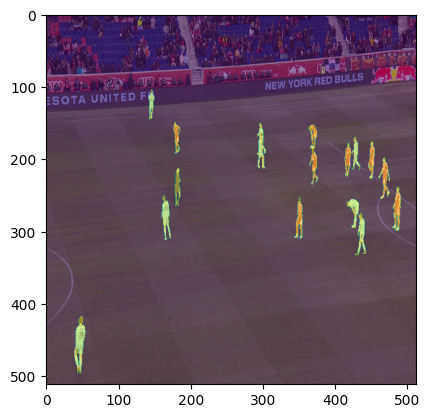

In [62]:
plt.imshow(images[0])
plt.imshow(masks[0], alpha=0.5)

In [63]:
from sklearn.model_selection import train_test_split

images_train, images_test, masks_train, masks_test = train_test_split(images,
                                                                      masks,
                                                                      test_size=0.05,
                                                                      random_state=42)

In [64]:
import tensorflow as tf
from keras.layers import *
from keras.models import Model
from keras.optimizers import Adam

# Определение архитектуры U-Net
def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Кодировщик
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Декодировщик
    up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(drop5)
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(64, 2, strides=(2), padding='same')(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same')(conv9)

    # Выходной слой
    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    # Определение модели
    model = Model(inputs=inputs, outputs=outputs)

    return model

In [65]:
unet_model = unet(input_size=(512, 512, 3))
# Компиляция модели
unet_model.compile(optimizer=Adam(learning_rate=1e-4),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [66]:
unet_result = unet_model.fit(images_train,
                             masks_train,
                             validation_split = 0.2,
                             batch_size = 4,
                             epochs = 5)

Epoch 1/5
97/97 [==============================] - 119s 1s/step - loss: 0.0556 - accuracy: 0.9816 - val_loss: 0.0251 - val_accuracy: 0.9934
Epoch 2/5
97/97 [==============================] - 119s 1s/step - loss: 0.0216 - accuracy: 0.9949 - val_loss: 0.0197 - val_accuracy: 0.9956
Epoch 3/5
97/97 [==============================] - 118s 1s/step - loss: 0.0181 - accuracy: 0.9962 - val_loss: 0.0179 - val_accuracy: 0.9964
Epoch 4/5
97/97 [==============================] - 116s 1s/step - loss: 0.0173 - accuracy: 0.9966 - val_loss: 0.0174 - val_accuracy: 0.9966
Epoch 5/5
97/97 [==============================] - 118s 1s/step - loss: 0.0167 - accuracy: 0.9969 - val_loss: 0.0169 - val_accuracy: 0.9970


In [67]:
unet_model.save('FPSegModel.h5')

In [68]:
unet_predict = unet_model.predict(images_test)

1/1 [==============================] - 0s 255ms/step


In [69]:
unet_predict = (unet_predict > 0.5).astype(np.uint8)

In [70]:
def iou_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou = np.sum(intersection) / np.sum(union)
    return iou

In [71]:
iou = iou_score(images_test, unet_predict)
print(f'IoU score: {iou}')

IoU score: 0.019392576570598175


In [72]:
def show_result(og, unet):
    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    axs[0].set_title("Original")
    axs[0].imshow(og)
    axs[0].axis('off')
    
    axs[1].set_title("U-Net")
    #unet = np.array(unet, dtype=np.float32)
    axs[1].imshow(unet)
    axs[1].axis('off')

    axs[2].set_title("Сombined")
    axs[2].imshow(og)
    axs[2].imshow(unet, alpha=0.5)

    plt.show()

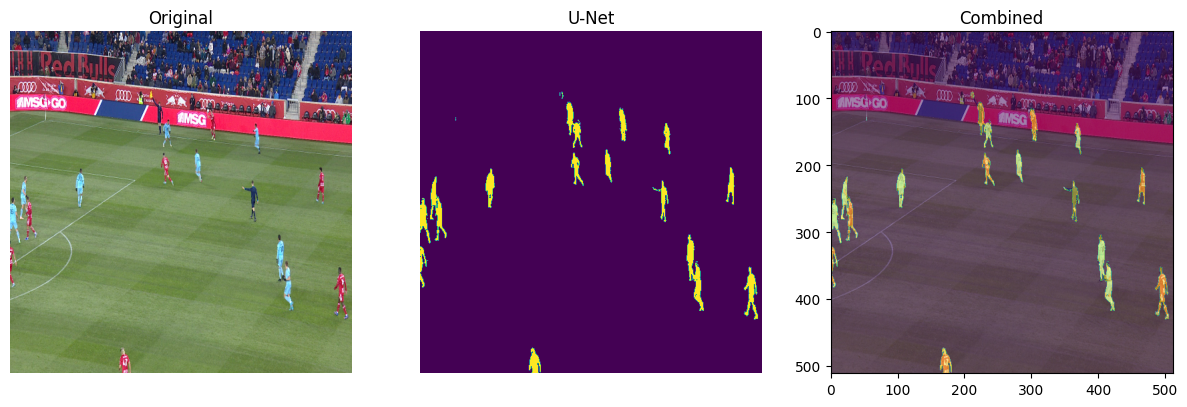

In [84]:
idx = 20
show_result(images_test[idx], unet_predict[idx])